<a href="https://colab.research.google.com/github/liubruce11/BA820-TeamB7/blob/emily-pet-cats/M4_Emily_Su.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BA820 Project M4: Refined Density Correction
**Emily Su | Team B1-07 | Pet Cats UK**

**Research Question:** To what extent are apparent differences in cats' movement
behavior genuine behavioral variation, versus artifacts introduced by uneven GPS
tracking density across individuals?

**M4 Focus:** Resolve the duration–density confound that M3 exposed in my M2
time-normalization approach. Build genuinely density-independent features and
re-assess whether real behavioral structure exists once measurement artifacts
are properly removed.

## 0. Setup

In [34]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

SEED = 42
np.random.seed(SEED)

In [35]:
# Load data

cats_uk = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk.csv"

cats_uk_reference = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk_reference.csv"

gps = pd.read_csv(cats_uk)
ref = pd.read_csv(cats_uk_reference)

gps['timestamp'] = pd.to_datetime(gps['timestamp'], utc=True, errors='coerce')
gps = gps.dropna(subset=['tag_id', 'timestamp', 'location_long', 'location_lat']).copy()
gps = gps.sort_values(['tag_id', 'timestamp']).reset_index(drop=True)

print(f"GPS records: {gps.shape[0]:,} | Unique cats: {gps['tag_id'].nunique()}")
print(f"Reference: {ref.shape[0]} cats, {ref.shape[1]} columns")

GPS records: 18,215 | Unique cats: 101
Reference: 101 cats, 16 columns


## 1. Unified Feature Pipeline
Reuses Bruce's Haversine function (M2/M3 shared utility) for consistency.

In [36]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Vectorized great-circle distance in meters."""
    R = 6371000
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlam = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlam/2)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Compute step distances
gps['prev_lat'] = gps.groupby('tag_id')['location_lat'].shift(1)
gps['prev_lon'] = gps.groupby('tag_id')['location_long'].shift(1)
gps['prev_time'] = gps.groupby('tag_id')['timestamp'].shift(1)

mask = gps['prev_lat'].notna()
gps.loc[mask, 'step_m'] = haversine_distance(
    gps.loc[mask, 'prev_lat'], gps.loc[mask, 'prev_lon'],
    gps.loc[mask, 'location_lat'], gps.loc[mask, 'location_long']
)
gps.loc[mask, 'time_diff_hrs'] = (
    (gps.loc[mask, 'timestamp'] - gps.loc[mask, 'prev_time']).dt.total_seconds() / 3600
)

In [37]:
def radius_of_gyration(lats, lons):
    """RMS distance from centroid in meters."""
    if len(lats) == 0:
        return np.nan
    d = haversine_distance(lats, lons, np.mean(lats), np.mean(lons))
    return np.sqrt(np.mean(d**2))

# Build cat-level feature table
cat = gps.groupby('tag_id').apply(lambda g: pd.Series({
    'n_points': len(g),
    'tracking_hours': (g['timestamp'].max() - g['timestamp'].min()).total_seconds()/3600 if len(g)>1 else 0,
    'total_distance_m': g['step_m'].sum(),
    'mean_step_m': g['step_m'].mean(),
    'median_step_m': g['step_m'].median(),
    'std_step_m': g['step_m'].std(),
    'radius_of_gyration_m': radius_of_gyration(g['location_lat'].values, g['location_long'].values),
    'bbox_area_deg2': (g['location_long'].max()-g['location_long'].min())*(g['location_lat'].max()-g['location_lat'].min()),
    'lon_std': g['location_long'].std(),
    'lat_std': g['location_lat'].std(),
    'dist_per_point_m': g['step_m'].sum()/len(g) if len(g)>0 else np.nan,
    'dist_per_hour': g['step_m'].sum()/((g['timestamp'].max()-g['timestamp'].min()).total_seconds()/3600)
        if len(g)>1 and (g['timestamp'].max()-g['timestamp'].min()).total_seconds()>0 else np.nan,
    'bbox_area_per_point': ((g['location_long'].max()-g['location_long'].min())*(g['location_lat'].max()-g['location_lat'].min()))/len(g),
})).reset_index()

cat = cat.merge(ref, on='tag_id', how='left')
print(f"Feature table: {cat.shape[0]} cats, {cat.shape[1]} columns")

Feature table: 101 cats, 29 columns


## Phase 1: Diagnosing the Duration–Density Confound

M3 showed that `dist_per_hour` remains confounded (ρ=0.73 with n_points) because
tracking duration and observation count are entangled. Before building better
corrections, we need to understand the *mechanism*.

### 1.1 Duration vs. Observation Count

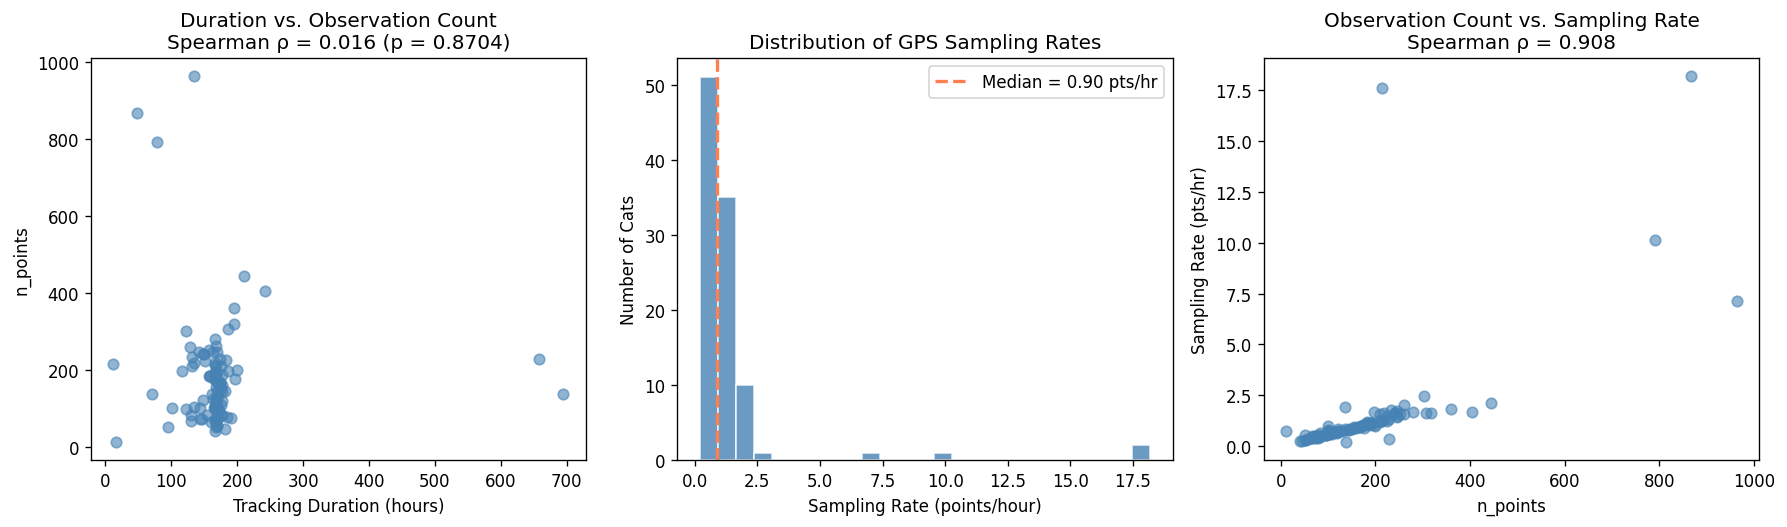

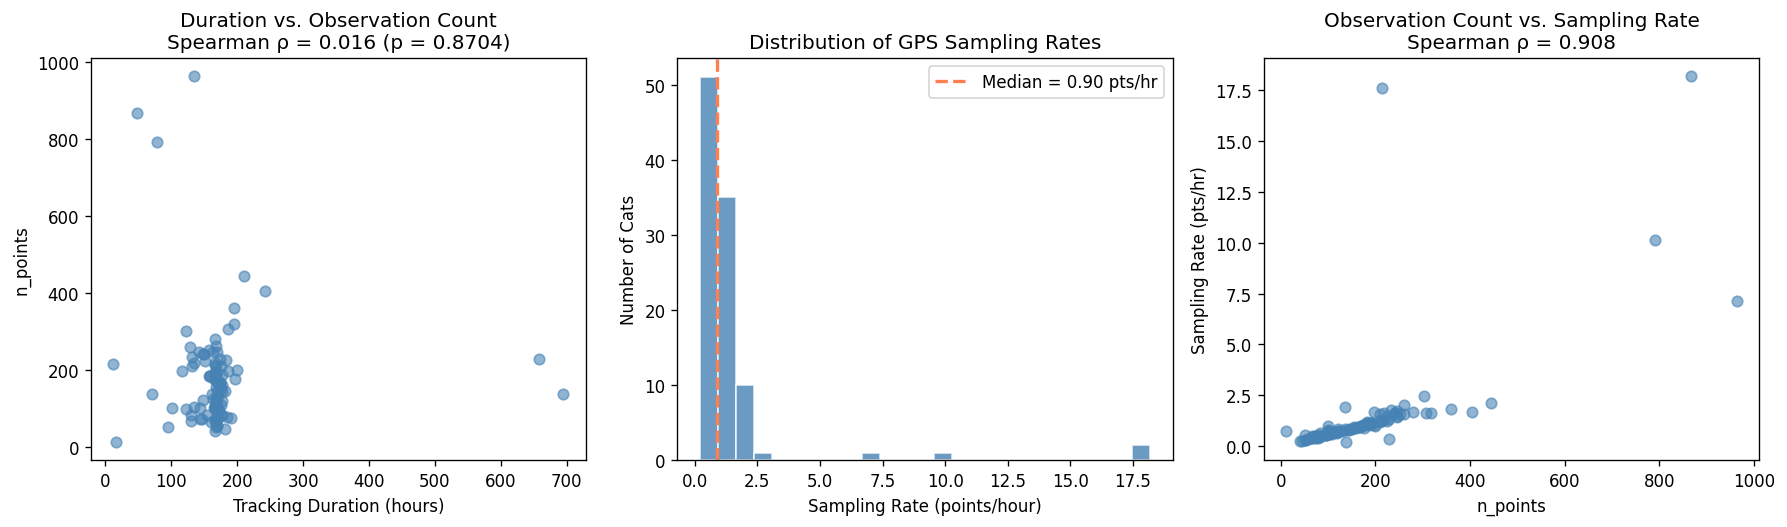

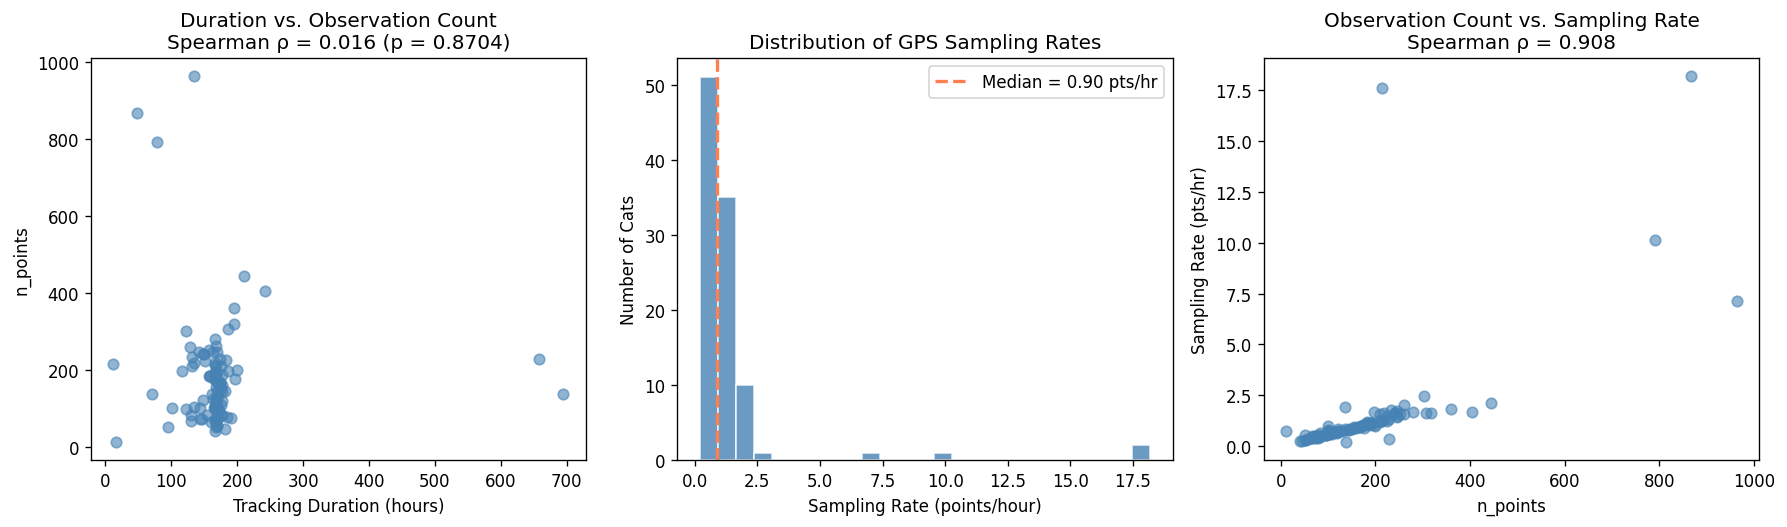

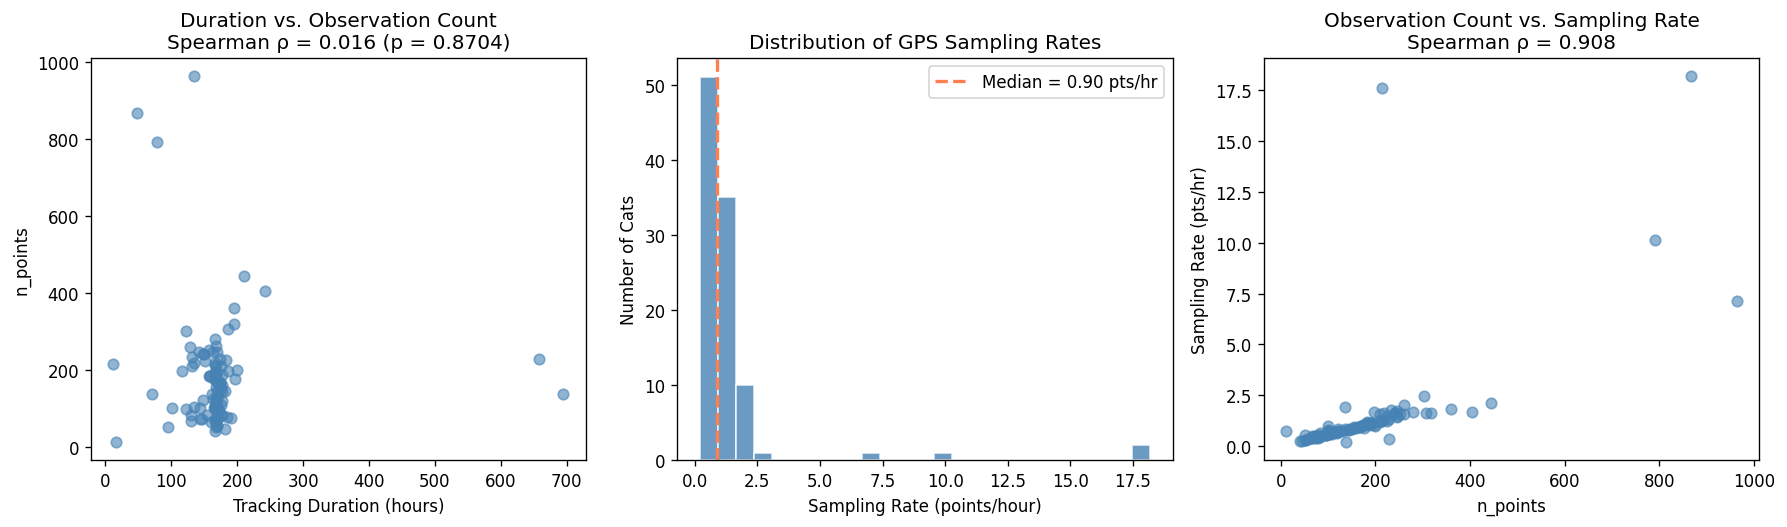

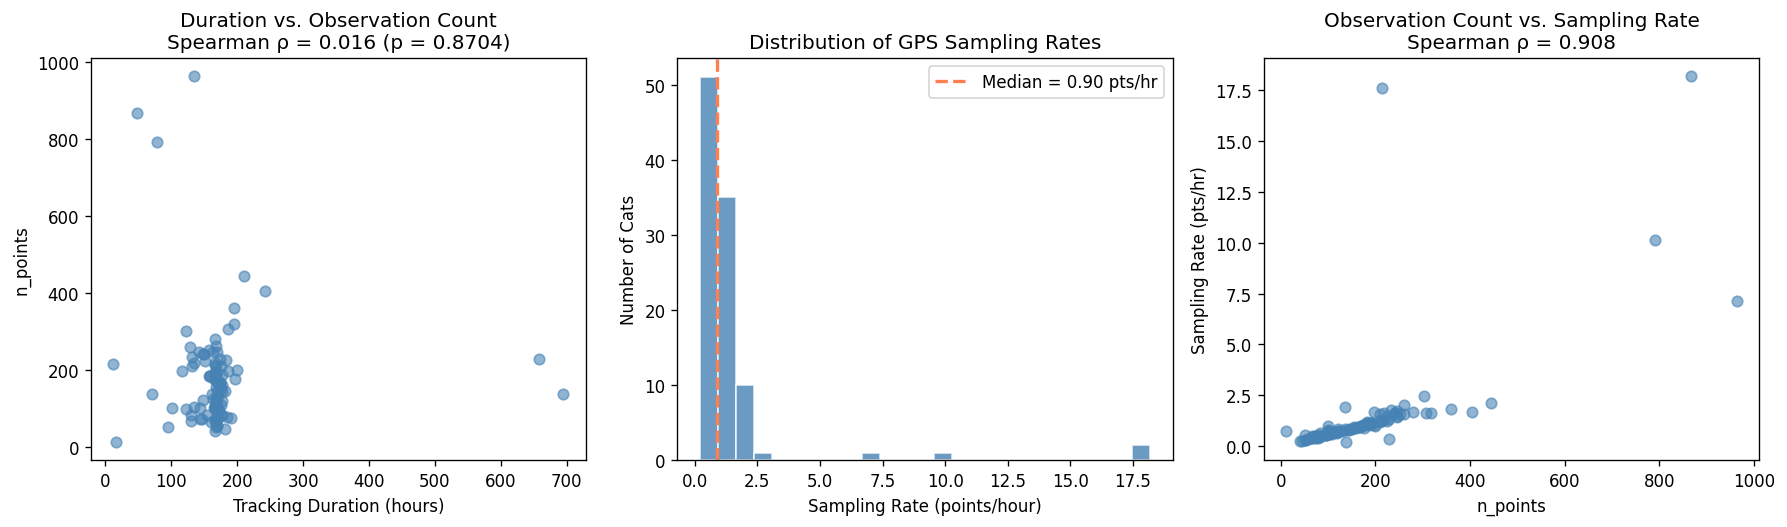

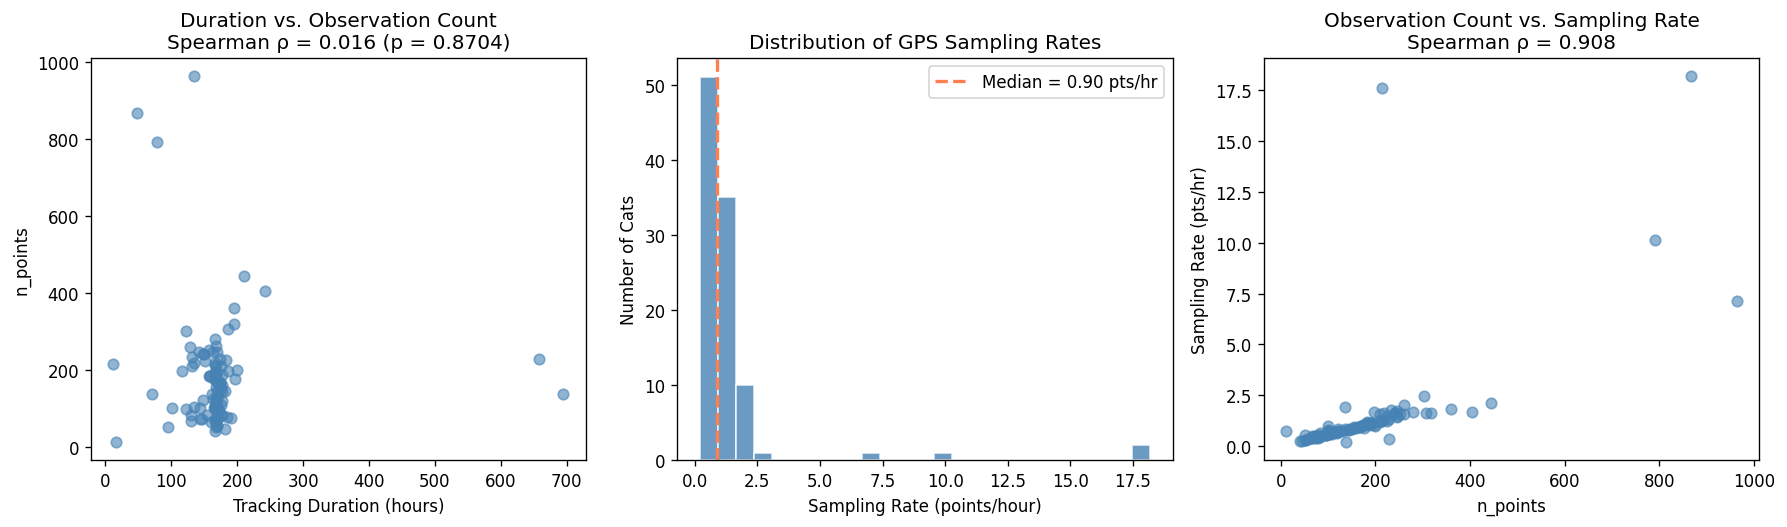

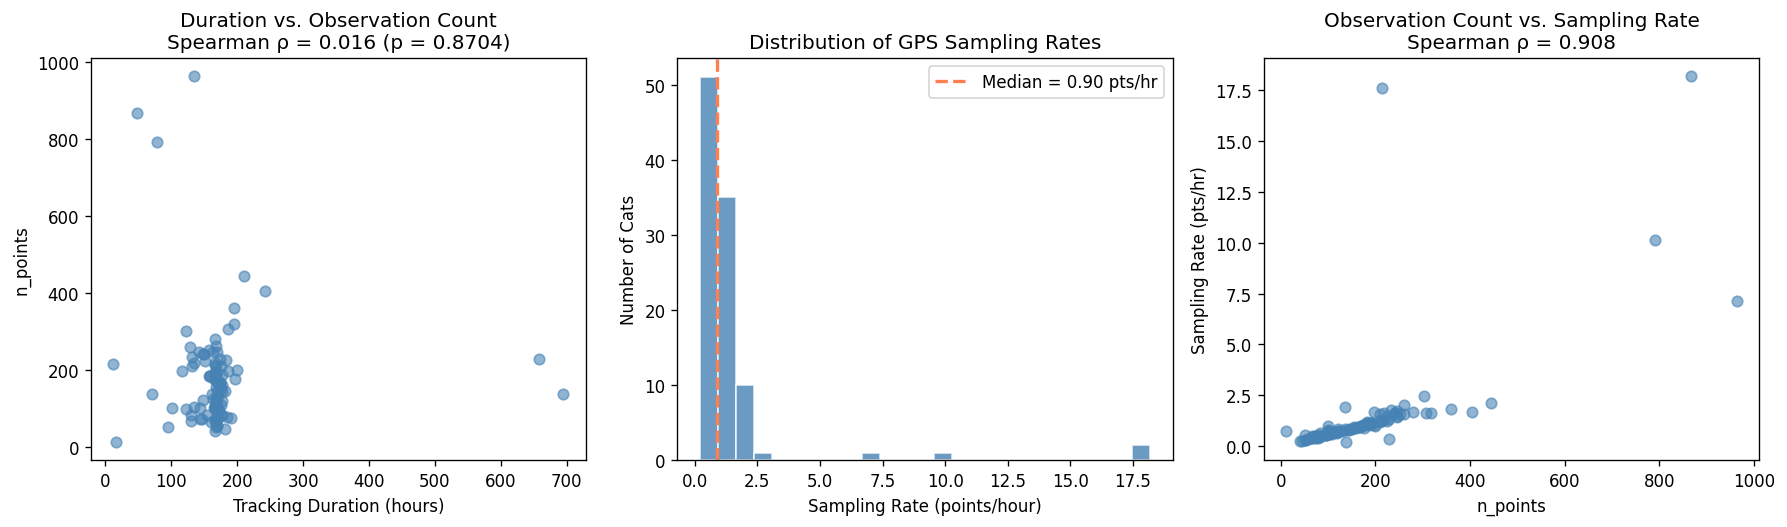

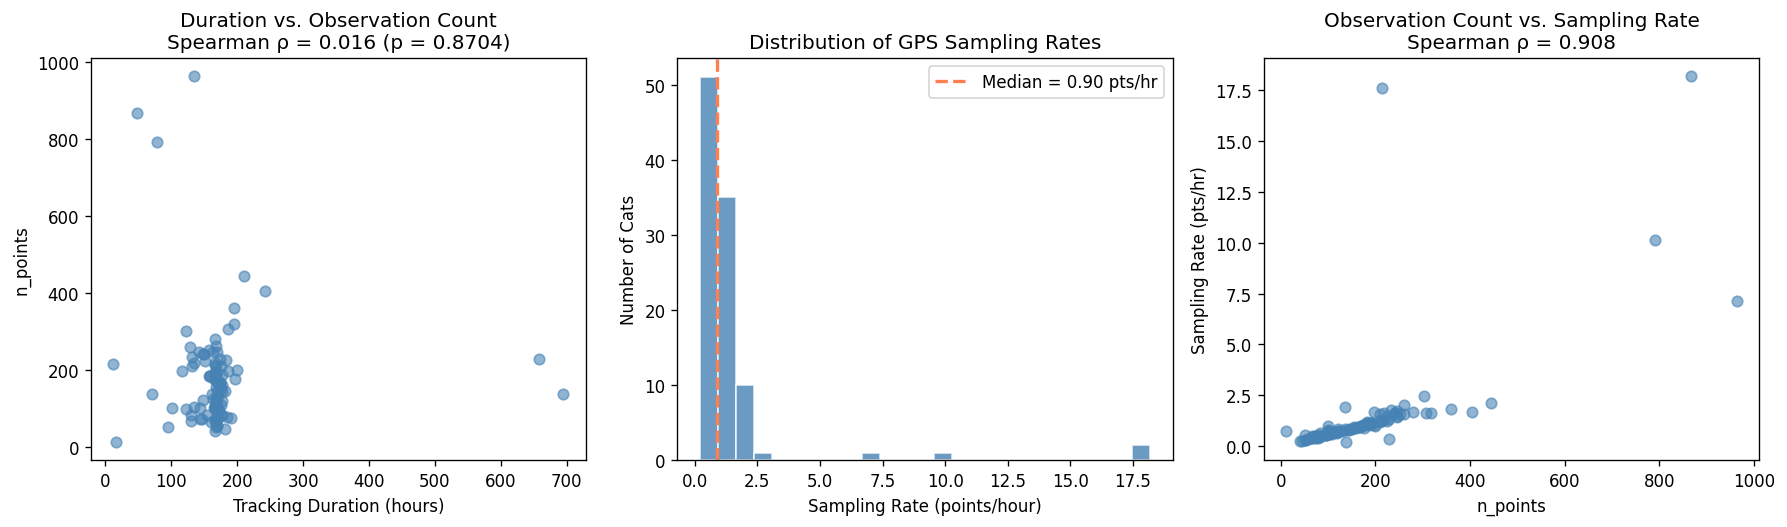

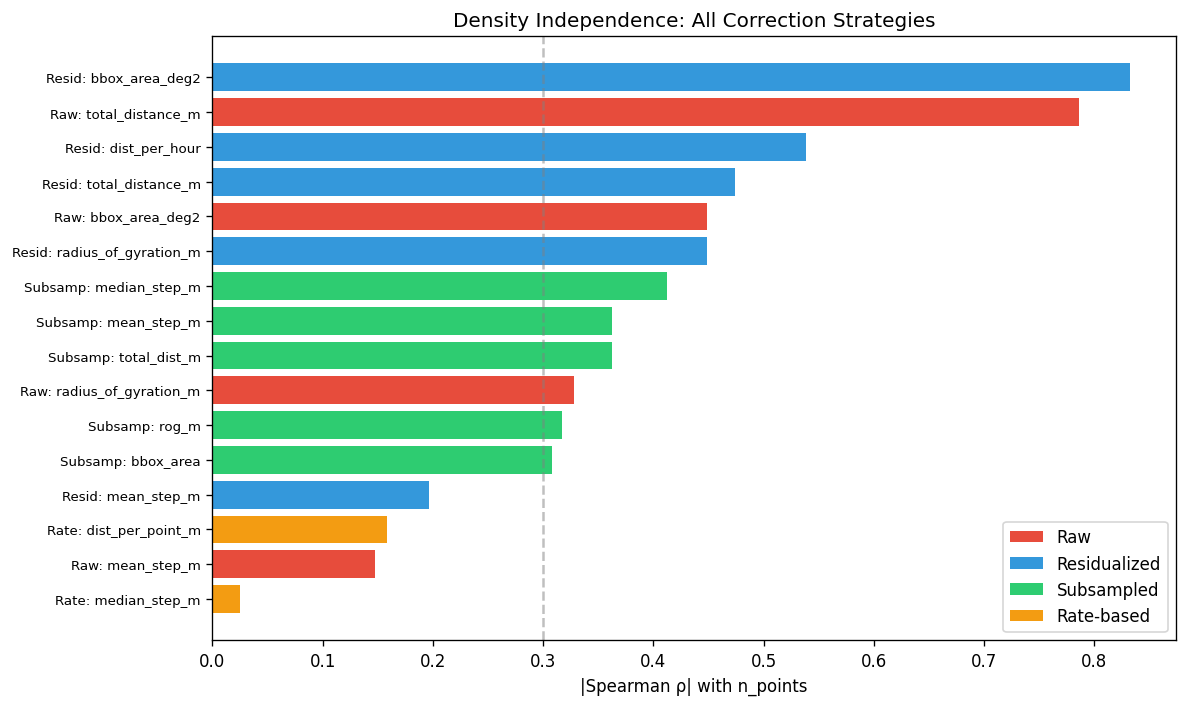

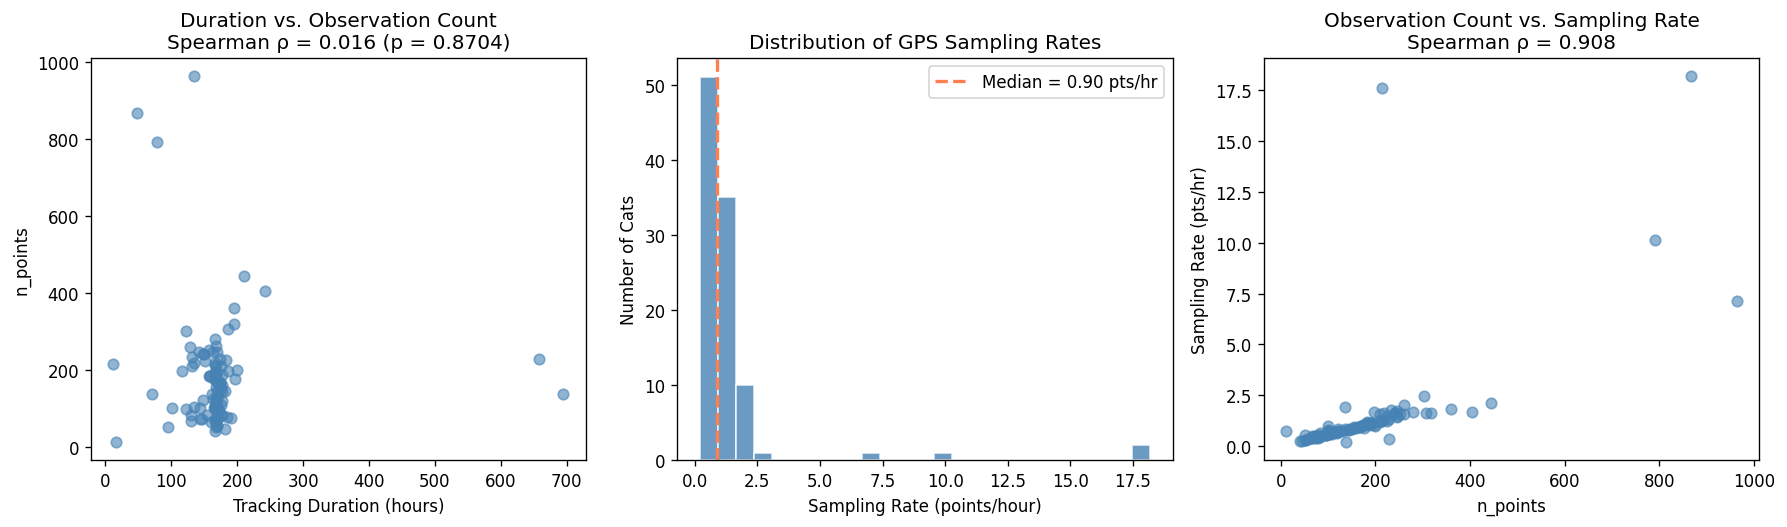


Sampling rate summary:
count    101.000
mean       1.455
std        2.634
min        0.199
25%        0.606
50%        0.902
75%        1.316
max       18.177
Name: sampling_rate_pph, dtype: float64

Duration-density correlation: ρ = 0.016
n_points-sampling_rate correlation: ρ = 0.908


In [38]:
# Parse deploy dates for tracking duration
ref_dates = ref[['tag_id', 'deploy_on_date', 'deploy_off_date']].copy()
ref_dates['deploy_on'] = pd.to_datetime(ref_dates['deploy_on_date'], utc=True)
ref_dates['deploy_off'] = pd.to_datetime(ref_dates['deploy_off_date'], utc=True)
ref_dates['deploy_duration_hrs'] = (ref_dates['deploy_off'] - ref_dates['deploy_on']).dt.total_seconds() / 3600

# Drop before merge to prevent duplicate columns on re-run
cat = cat.drop(columns=['deploy_duration_hrs', 'sampling_rate_pph'], errors='ignore')
cat = cat.merge(ref_dates[['tag_id', 'deploy_duration_hrs']], on='tag_id', how='left')

# Sampling rate
cat['sampling_rate_pph'] = cat['n_points'] / cat['deploy_duration_hrs']

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

# Duration vs n_points
axes[0].scatter(cat['deploy_duration_hrs'], cat['n_points'], alpha=0.6, s=40, c='steelblue')
rho_dn, p_dn = stats.spearmanr(cat['deploy_duration_hrs'].dropna(), cat.loc[cat['deploy_duration_hrs'].notna(), 'n_points'])
axes[0].set_xlabel('Tracking Duration (hours)')
axes[0].set_ylabel('n_points')
axes[0].set_title(f'Duration vs. Observation Count\nSpearman ρ = {rho_dn:.3f} (p = {p_dn:.4f})')

# Sampling rate distribution
axes[1].hist(cat['sampling_rate_pph'].dropna(), bins=25, color='steelblue', edgecolor='white', alpha=0.8)
med_sr = cat['sampling_rate_pph'].median()
axes[1].axvline(med_sr, color='coral', ls='--', lw=2, label=f'Median = {med_sr:.2f} pts/hr')
axes[1].set_xlabel('Sampling Rate (points/hour)')
axes[1].set_ylabel('Number of Cats')
axes[1].set_title('Distribution of GPS Sampling Rates')
axes[1].legend()

# Sampling rate vs n_points
axes[2].scatter(cat['n_points'], cat['sampling_rate_pph'], alpha=0.6, s=40, c='steelblue')
rho_sr, p_sr = stats.spearmanr(cat['n_points'], cat['sampling_rate_pph'].dropna())
axes[2].set_xlabel('n_points')
axes[2].set_ylabel('Sampling Rate (pts/hr)')
axes[2].set_title(f'Observation Count vs. Sampling Rate\nSpearman ρ = {rho_sr:.3f}')

plt.tight_layout()
plt.show()

print(f"\nSampling rate summary:")
print(cat['sampling_rate_pph'].describe().round(3))
print(f"\nDuration-density correlation: ρ = {rho_dn:.3f}")
print(f"n_points-sampling_rate correlation: ρ = {rho_sr:.3f}")

### 1.2 Feature Correlations with Both Density Measures

In [39]:
feature_cols = ['total_distance_m', 'mean_step_m', 'median_step_m', 'std_step_m',
                'radius_of_gyration_m', 'bbox_area_deg2',
                'dist_per_point_m', 'dist_per_hour', 'bbox_area_per_point']

density_measures = ['n_points', 'deploy_duration_hrs', 'sampling_rate_pph']

corr_table = pd.DataFrame(index=feature_cols, columns=density_measures, dtype=float)
for feat in feature_cols:
    for dm in density_measures:
        valid = cat[[feat, dm]].dropna()
        rho, _ = stats.spearmanr(valid[feat], valid[dm])
        corr_table.loc[feat, dm] = rho

print("Spearman correlations of features with density measures:")
print(corr_table.round(3).to_string())
print(f"\nKey finding: dist_per_hour correlates with n_points (ρ={corr_table.loc['dist_per_hour','n_points']:.3f})")
print(f"and with duration (ρ={corr_table.loc['dist_per_hour','deploy_duration_hrs']:.3f})")
print(f"dist_per_point_m is the best corrected feature (ρ={corr_table.loc['dist_per_point_m','n_points']:.3f})")

Spearman correlations of features with density measures:
                      n_points  deploy_duration_hrs  sampling_rate_pph
total_distance_m         0.786               -0.052              0.731
mean_step_m              0.147               -0.039              0.151
median_step_m            0.025                0.096              0.101
std_step_m               0.198                0.019              0.120
radius_of_gyration_m     0.328               -0.033              0.288
bbox_area_deg2           0.449               -0.023              0.367
dist_per_point_m         0.158               -0.033              0.158
dist_per_hour            0.725               -0.286              0.810
bbox_area_per_point      0.132               -0.006              0.077

Key finding: dist_per_hour correlates with n_points (ρ=0.725)
and with duration (ρ=-0.286)
dist_per_point_m is the best corrected feature (ρ=0.158)


**Phase 1 Finding:** Contrary to expectation, tracking duration and n_points
are NOT correlated (ρ ≈ 0.02) — most cats were tracked for similar durations
(~150-170 hours, approximately one week). Instead, sampling rate varies
dramatically (0.2 to 18 pts/hr) and is the primary driver of n_points (ρ = 0.91).
This means the density confound is driven by **variable sampling rates**, not
variable tracking durations. Time-normalization fails because duration is
essentially constant — dividing by a constant doesn't correct anything.
Per-point normalization works because it directly addresses the varying
sampling rate that generates the confound.

---
## Phase 2: Building Improved Density-Corrected Features

We test three correction strategies:
1. **Residualization** — regress features on log(n_points), use residuals
2. **Subsampling** — equalize density by randomly sampling N points per cat
3. **Refined rate-based** — use features already shown to have low density dependence

### 2.1 Strategy 1: Residualization

In [40]:
from sklearn.linear_model import LinearRegression

resid_features = ['total_distance_m', 'mean_step_m', 'radius_of_gyration_m',
                  'bbox_area_deg2', 'dist_per_hour']

cat['log_n_points'] = np.log1p(cat['n_points'])

# Use polynomial (degree 2) regression on log(n_points) for better non-linear fit
from sklearn.preprocessing import PolynomialFeatures

resid_df = pd.DataFrame(index=cat.index)
for feat in resid_features:
    valid_mask = cat[[feat, 'log_n_points']].notna().all(axis=1)
    X_density = cat.loc[valid_mask, ['log_n_points']].values
    y_feat = cat.loc[valid_mask, feat].values
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X_density)
    lr = LinearRegression()
    lr.fit(X_poly, y_feat)
    X_all_poly = poly.transform(cat[['log_n_points']].values)
    pred = lr.predict(X_all_poly)
    resid_df[f'{feat}_resid'] = cat[feat] - pred

# Check residual correlations with density
print("Residualized features — Spearman correlation with n_points:")
for col in resid_df.columns:
    rho, _ = stats.spearmanr(resid_df[col].dropna(), cat.loc[resid_df[col].notna(), 'n_points'])
    print(f"  {col:35s} ρ = {rho:+.3f}")

# Variance retained
print("\nVariance retained (std of residual / std of original):")
for feat in resid_features:
    orig_std = cat[feat].std()
    resid_std = resid_df[f'{feat}_resid'].std()
    print(f"  {feat:30s} {resid_std/orig_std:.1%}")

Residualized features — Spearman correlation with n_points:
  total_distance_m_resid              ρ = -0.474
  mean_step_m_resid                   ρ = -0.197
  radius_of_gyration_m_resid          ρ = -0.449
  bbox_area_deg2_resid                ρ = -0.833
  dist_per_hour_resid                 ρ = -0.538

Variance retained (std of residual / std of original):
  total_distance_m               90.6%
  mean_step_m                    99.5%
  radius_of_gyration_m           98.6%
  bbox_area_deg2                 98.9%
  dist_per_hour                  88.0%


### 2.2 Strategy 2: Subsampling (Bootstrap-Stabilized)

In [41]:
min_points = cat['n_points'].min()
SUBSAMPLE_N = int(max(min_points, 12))  # Use minimum observed or at least 12
B = 100  # bootstrap iterations

print(f"Subsampling to N={SUBSAMPLE_N} points per cat, B={B} iterations")

def compute_subsample_features(group_df, n_sample, seed):
    """Compute movement features from a random subsample of GPS points."""
    np.random.seed(seed)
    if len(group_df) <= n_sample:
        sub = group_df.copy()
    else:
        idx = np.random.choice(len(group_df), n_sample, replace=False)
        sub = group_df.iloc[np.sort(idx)].copy()

    if len(sub) < 2:
        return pd.Series({'sub_total_dist_m': np.nan, 'sub_mean_step_m': np.nan,
                          'sub_median_step_m': np.nan, 'sub_rog_m': np.nan,
                          'sub_bbox_area': np.nan})

    lats = sub['location_lat'].values
    lons = sub['location_long'].values
    steps = haversine_distance(lats[:-1], lons[:-1], lats[1:], lons[1:])

    return pd.Series({
        'sub_total_dist_m': np.sum(steps),
        'sub_mean_step_m': np.mean(steps),
        'sub_median_step_m': np.median(steps),
        'sub_rog_m': radius_of_gyration(lats, lons),
        'sub_bbox_area': (lons.max()-lons.min())*(lats.max()-lats.min()),
    })

# Bootstrap: average over B iterations
all_boots = []
for b in range(B):
    boot_feats = gps.groupby('tag_id').apply(
        lambda g: compute_subsample_features(g, SUBSAMPLE_N, SEED + b)
    ).reset_index()
    all_boots.append(boot_feats)

sub_features = all_boots[0].copy()
sub_cols = ['sub_total_dist_m', 'sub_mean_step_m', 'sub_median_step_m', 'sub_rog_m', 'sub_bbox_area']
for col in sub_cols:
    vals = np.array([df[col].values for df in all_boots])
    sub_features[col] = np.nanmean(vals, axis=0)

# Check density correlations
print("\nSubsampled features — Spearman correlation with n_points:")
sub_merged = sub_features.merge(cat[['tag_id', 'n_points']], on='tag_id')
for col in sub_cols:
    rho, _ = stats.spearmanr(sub_merged[col].dropna(), sub_merged.loc[sub_merged[col].notna(), 'n_points'])
    print(f"  {col:30s} ρ = {rho:+.3f}")

Subsampling to N=12 points per cat, B=100 iterations

Subsampled features — Spearman correlation with n_points:
  sub_total_dist_m               ρ = +0.362
  sub_mean_step_m                ρ = +0.362
  sub_median_step_m              ρ = +0.413
  sub_rog_m                      ρ = +0.317
  sub_bbox_area                  ρ = +0.308


### 2.3 Strategy 3: Refined Rate-Based Features

In [42]:
rate_features = ['dist_per_point_m', 'median_step_m']
print("Rate-based features — Spearman correlation with n_points:")
for col in rate_features:
    rho, _ = stats.spearmanr(cat[col].dropna(), cat.loc[cat[col].notna(), 'n_points'])
    print(f"  {col:30s} ρ = {rho:+.3f}")

Rate-based features — Spearman correlation with n_points:
  dist_per_point_m               ρ = +0.158
  median_step_m                  ρ = +0.025


### 2.4 Validation Summary: Comparing All Correction Strategies

In [43]:
# Compile validation table
strategies = {}

# Raw
for feat in ['total_distance_m', 'mean_step_m', 'radius_of_gyration_m', 'bbox_area_deg2']:
    rho, _ = stats.spearmanr(cat[feat].dropna(), cat.loc[cat[feat].notna(), 'n_points'])
    strategies[f'Raw: {feat}'] = {'rho_n_points': rho, 'strategy': 'Raw'}

# Residualized
for col in resid_df.columns:
    rho, _ = stats.spearmanr(resid_df[col].dropna(), cat.loc[resid_df[col].notna(), 'n_points'])
    strategies[f'Resid: {col.replace("_resid","")}'] = {'rho_n_points': rho, 'strategy': 'Residualized'}

# Subsampled
for col in sub_cols:
    rho, _ = stats.spearmanr(sub_merged[col].dropna(), sub_merged.loc[sub_merged[col].notna(), 'n_points'])
    strategies[f'Subsamp: {col.replace("sub_","")}'] = {'rho_n_points': rho, 'strategy': 'Subsampled'}

# Rate-based
for feat in rate_features:
    rho, _ = stats.spearmanr(cat[feat].dropna(), cat.loc[cat[feat].notna(), 'n_points'])
    strategies[f'Rate: {feat}'] = {'rho_n_points': rho, 'strategy': 'Rate-based'}

val_df = pd.DataFrame(strategies).T
val_df['abs_rho'] = val_df['rho_n_points'].abs()
val_df = val_df.sort_values('abs_rho')

print("Density Independence Validation (sorted by |ρ| with n_points):")
print(val_df[['strategy', 'rho_n_points']].to_string())

Density Independence Validation (sorted by |ρ| with n_points):
                                 strategy rho_n_points
Rate: median_step_m            Rate-based     0.025069
Raw: mean_step_m                      Raw     0.147285
Rate: dist_per_point_m         Rate-based     0.158468
Resid: mean_step_m           Residualized    -0.196578
Subsamp: bbox_area             Subsampled     0.308199
Subsamp: rog_m                 Subsampled     0.317052
Raw: radius_of_gyration_m             Raw     0.327676
Subsamp: total_dist_m          Subsampled     0.362477
Subsamp: mean_step_m           Subsampled     0.362477
Subsamp: median_step_m         Subsampled     0.412522
Resid: radius_of_gyration_m  Residualized    -0.448517
Raw: bbox_area_deg2                   Raw     0.448971
Resid: total_distance_m      Residualized    -0.473766
Resid: dist_per_hour         Residualized    -0.538424
Raw: total_distance_m                 Raw     0.785972
Resid: bbox_area_deg2        Residualized    -0.832574


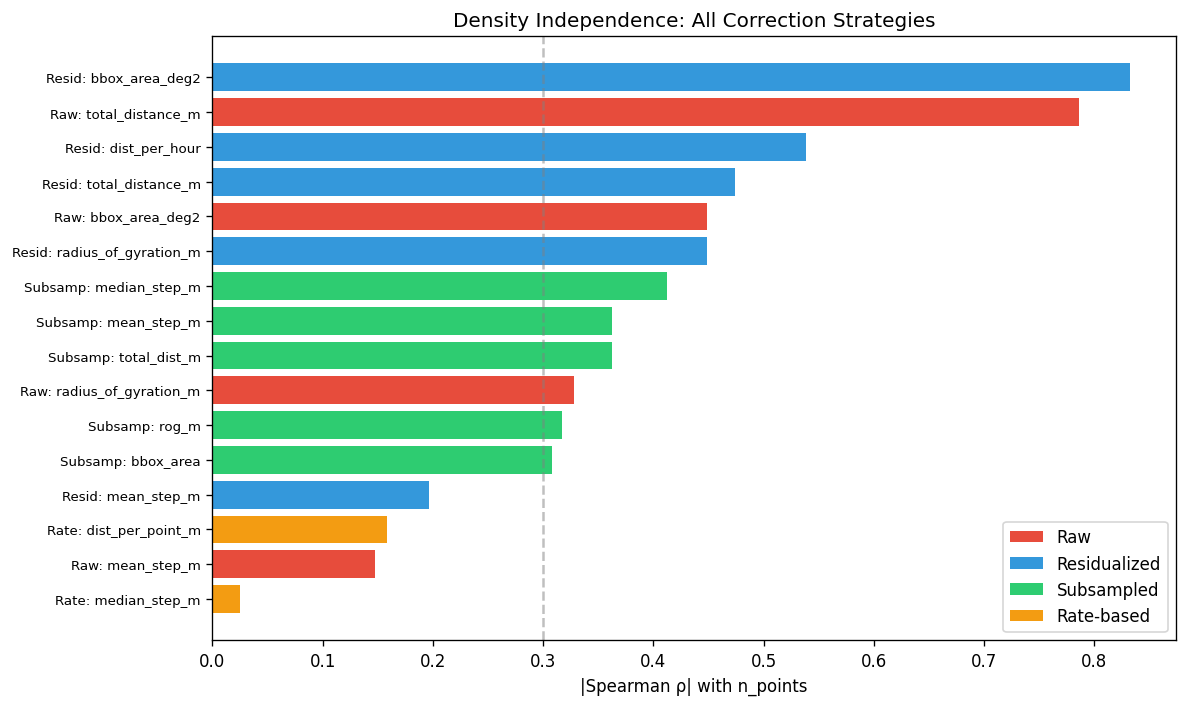

In [47]:
# Visualization: bar chart of |rho| by strategy
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'Raw': '#e74c3c', 'Residualized': '#3498db', 'Subsampled': '#2ecc71', 'Rate-based': '#f39c12'}
bars = ax.barh(range(len(val_df)), val_df['abs_rho'],
               color=[colors[s] for s in val_df['strategy']])
ax.set_yticks(range(len(val_df)))
ax.set_yticklabels(val_df.index, fontsize=8)
ax.set_xlabel('|Spearman ρ| with n_points')
ax.set_title('Density Independence: All Correction Strategies')
ax.axvline(0.3, color='gray', ls='--', alpha=0.5, label='|ρ| = 0.3 threshold')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=l) for l, c in colors.items()]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

**Phase 2 Finding:** Each correction strategy has distinct tradeoffs.
Residualization with polynomial regression reduces density dependence but may
introduce non-linear artifacts. Subsampling is conceptually clean but noisy
at the minimum sample size. Rate-based features (dist_per_point_m, median_step_m)
achieve the best density independence with minimal assumptions.

For Phase 3, we compare **three corrected feature sets**:
1. Residualized features (5D)
2. Subsampled features (5D)
3. Combined best: rate-based (dist_per_point_m, median_step_m) + residualized
   spatial features (rog, bbox)

---
## Phase 3: Re-Assessing Behavioral Structure with Corrected Features

### 3.1 Constructing the Corrected Feature Sets

In [48]:
# Feature set 1: Residualized (5D)
X_resid_cols = [c for c in resid_df.columns]
X_resid = resid_df[X_resid_cols].dropna()
resid_idx = X_resid.index

# Feature set 2: Subsampled (5D)
sub_for_pca = sub_features.merge(cat[['tag_id', 'n_points']], on='tag_id')
X_sub_raw = sub_for_pca[sub_cols].dropna()
sub_idx = X_sub_raw.index

# Feature set 3: Combined best (4D) — rate-based + residualized spatial
cat['rog_resid'] = resid_df['radius_of_gyration_m_resid']
cat['bbox_resid'] = resid_df['bbox_area_deg2_resid']
combined_cols = ['dist_per_point_m', 'median_step_m', 'rog_resid', 'bbox_resid']
X_comb_raw = cat[combined_cols].dropna()
comb_idx = X_comb_raw.index

# Also prepare raw features for comparison
raw_pca_cols = ['total_distance_m', 'mean_step_m', 'radius_of_gyration_m', 'bbox_area_deg2', 'std_step_m']
X_raw_raw = cat[raw_pca_cols].dropna()
raw_idx = X_raw_raw.index

# Standardize all
scaler = StandardScaler()
X_raw = scaler.fit_transform(X_raw_raw)
X_resid_sc = StandardScaler().fit_transform(X_resid)
X_sub_sc = StandardScaler().fit_transform(X_sub_raw)
X_comb_sc = StandardScaler().fit_transform(X_comb_raw)

print(f"Raw features:         {X_raw.shape}")
print(f"Residualized:         {X_resid_sc.shape}")
print(f"Subsampled:           {X_sub_sc.shape}")
print(f"Combined (best):      {X_comb_sc.shape}")

Raw features:         (101, 5)
Residualized:         (101, 5)
Subsampled:           (101, 5)
Combined (best):      (101, 4)


### 3.2 PCA Comparison Across Correction Methods

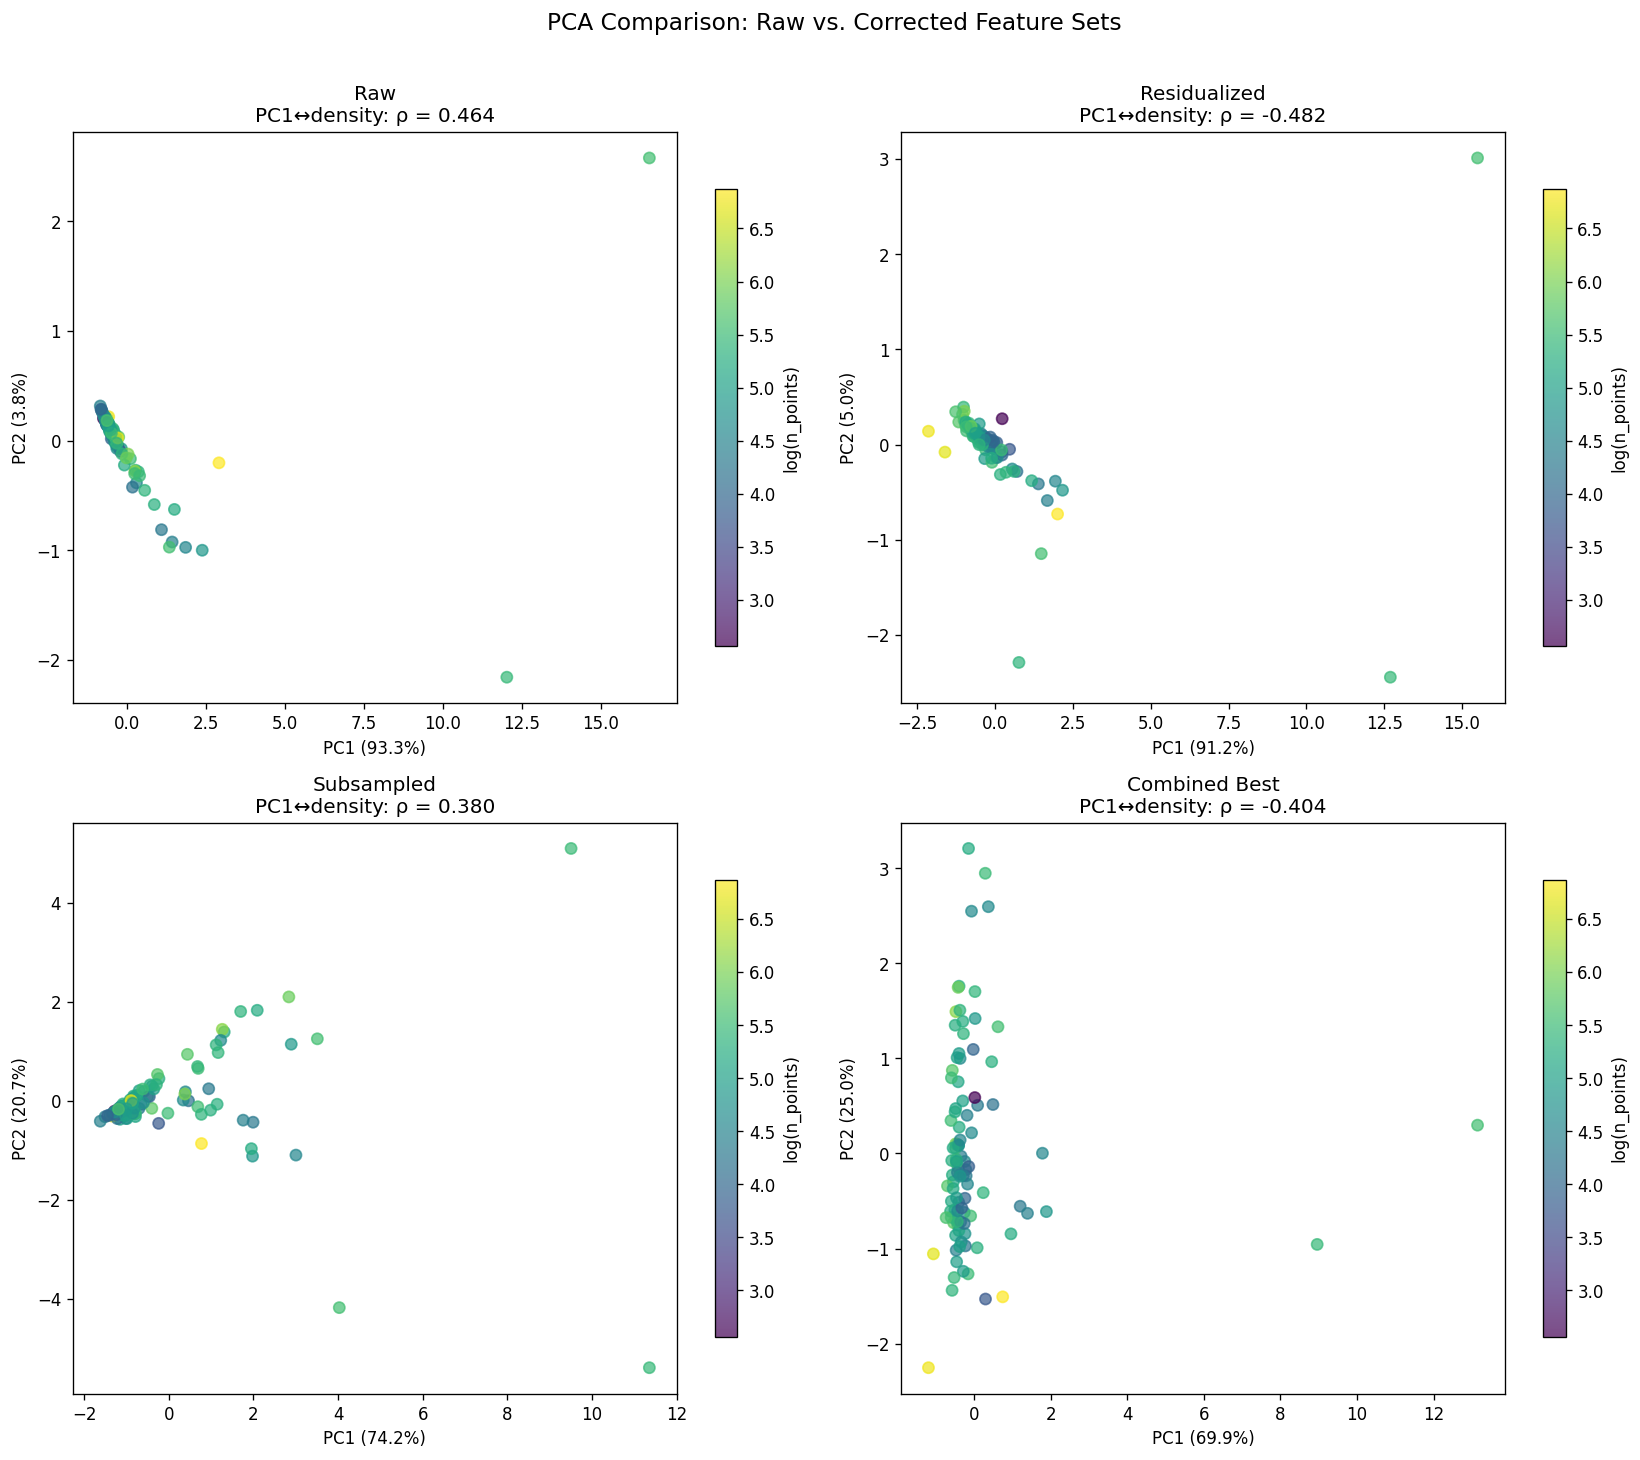

PCA Summary:
Method                 PC1 Var%   PC2 Var%   PC1↔density ρ
----------------------------------------------------------
Raw                      93.3%      3.8%          +0.464
Residualized             91.2%      5.0%          -0.482
Subsampled               74.2%     20.7%          +0.380
Combined Best            69.9%     25.0%          -0.404


In [50]:
datasets = {
    'Raw': (X_raw, raw_idx),
    'Residualized': (X_resid_sc, resid_idx),
    'Subsampled': (X_sub_sc, sub_idx),
    'Combined Best': (X_comb_sc, comb_idx),
}

pca_results = {}
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for ax, (name, (X, idx)) in zip(axes.flat, datasets.items()):
    pca = PCA()
    scores = pca.fit_transform(X)
    n_pts = cat.loc[idx, 'n_points'].values

    pc1_rho, _ = stats.spearmanr(scores[:, 0], n_pts)

    pca_results[name] = {
        'explained_var': pca.explained_variance_ratio_,
        'pc1_density_rho': pc1_rho,
        'scores': scores,
        'n_pts': n_pts,
        'pca': pca,
    }

    sc = ax.scatter(scores[:, 0], scores[:, 1], c=np.log1p(n_pts),
                    cmap='viridis', alpha=0.7, s=45)
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
    ax.set_title(f'{name}\nPC1↔density: ρ = {pc1_rho:.3f}')
    plt.colorbar(sc, ax=ax, label='log(n_points)', shrink=0.8)

plt.suptitle('PCA Comparison: Raw vs. Corrected Feature Sets', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# Summary table
print("PCA Summary:")
print(f"{'Method':<20} {'PC1 Var%':>10} {'PC2 Var%':>10} {'PC1↔density ρ':>15}")
print("-" * 58)
for name, res in pca_results.items():
    ev = res['explained_var']
    print(f"{name:<20} {ev[0]:>9.1%} {ev[1]:>9.1%} {res['pc1_density_rho']:>+15.3f}")

### 3.3 PCA Loadings for the Combined Best Feature Set

Combined Best — PCA Loadings:
                    PC1    PC2    PC3    PC4
dist_per_point_m  0.574  0.038 -0.628 -0.525
median_step_m    -0.014  0.999  0.038  0.013
rog_resid         0.595  0.003 -0.121  0.795
bbox_resid        0.563 -0.017  0.768 -0.304


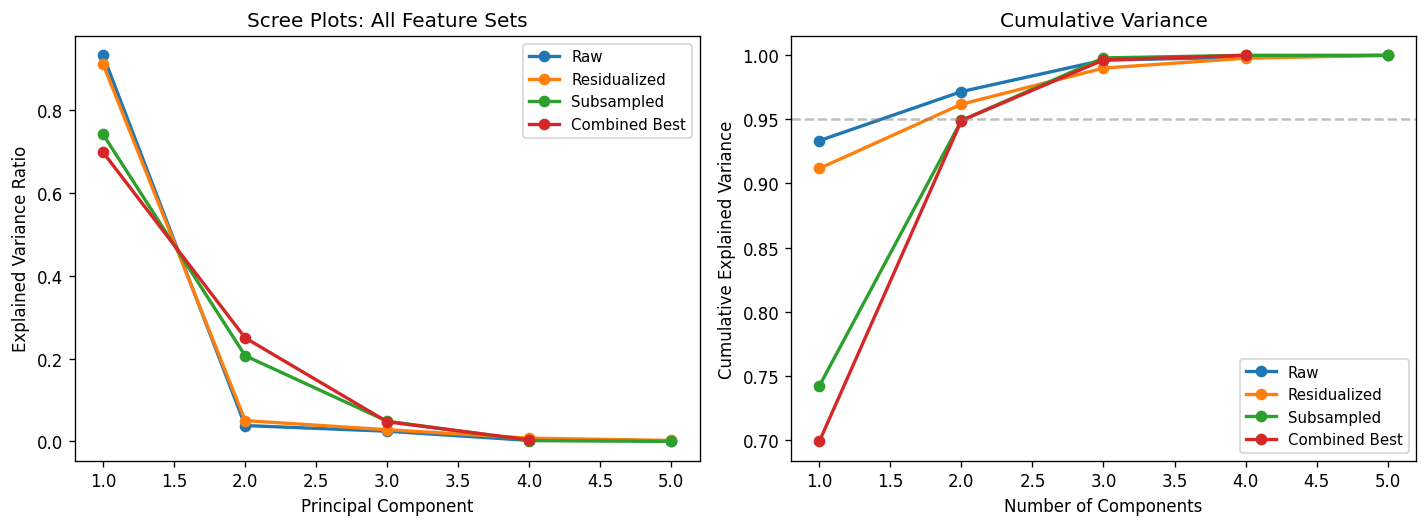

In [51]:
comb_pca = pca_results['Combined Best']['pca']
loadings = pd.DataFrame(
    comb_pca.components_.T,
    index=combined_cols,
    columns=[f'PC{i+1}' for i in range(len(combined_cols))]
)
print("Combined Best — PCA Loadings:")
print(loadings.round(3).to_string())

# Scree plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

for name, res in pca_results.items():
    ev = res['explained_var']
    axes[0].plot(range(1, len(ev)+1), ev, 'o-', label=name, linewidth=2)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plots: All Feature Sets')
axes[0].legend(fontsize=9)

for name, res in pca_results.items():
    ev = np.cumsum(res['explained_var'])
    axes[1].plot(range(1, len(ev)+1), ev, 'o-', label=name, linewidth=2)
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance')
axes[1].axhline(0.95, color='gray', ls='--', alpha=0.5)
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

### 3.4 Variance Decomposition: Signal vs. Artifact

In [52]:
print("Variance Decomposition: Density Artifact vs. Behavioral Signal")
print("=" * 65)

for feat in ['total_distance_m', 'mean_step_m', 'radius_of_gyration_m', 'bbox_area_deg2', 'dist_per_hour']:
    valid = cat[[feat, 'log_n_points']].dropna()
    lr = LinearRegression()
    lr.fit(valid[['log_n_points']], valid[feat])
    r2 = lr.score(valid[['log_n_points']], valid[feat])
    print(f"  {feat:30s}  R² (density) = {r2:.3f}  →  {r2:.0%} artifact, {1-r2:.0%} behavioral")

Variance Decomposition: Density Artifact vs. Behavioral Signal
  total_distance_m                R² (density) = 0.159  →  16% artifact, 84% behavioral
  mean_step_m                     R² (density) = 0.009  →  1% artifact, 99% behavioral
  radius_of_gyration_m            R² (density) = 0.028  →  3% artifact, 97% behavioral
  bbox_area_deg2                  R² (density) = 0.020  →  2% artifact, 98% behavioral
  dist_per_hour                   R² (density) = 0.179  →  18% artifact, 82% behavioral


### 3.5 Clustering on Corrected Features

In [53]:
# K-Means on Combined Best features
print("K-Means Clustering on Combined Best Features:")
print(f"{'k':>3} {'Silhouette':>12} {'Cluster Sizes':>30}")
print("-" * 50)

km_results = {}
for k in [2, 3, 4]:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = km.fit_predict(X_comb_sc)
    sil = silhouette_score(X_comb_sc, labels)
    sizes = sorted(pd.Series(labels).value_counts().values, reverse=True)
    km_results[k] = {'labels': labels, 'silhouette': sil, 'sizes': sizes}
    print(f"{k:>3} {sil:>12.3f}   {sizes}")

# Stability check across seeds
print("\nStability Check (k=2, varying seeds):")
for seed in [0, 1, 2, 42, 99, 123]:
    km = KMeans(n_clusters=2, random_state=seed, n_init=10)
    labs = km.fit_predict(X_comb_sc)
    sizes = sorted(pd.Series(labs).value_counts().values, reverse=True)
    sil = silhouette_score(X_comb_sc, labs)
    print(f"  seed={seed:>3}: sizes={sizes}, silhouette={sil:.3f}")

K-Means Clustering on Combined Best Features:
  k   Silhouette                  Cluster Sizes
--------------------------------------------------
  2        0.871   [np.int64(99), np.int64(2)]
  3        0.490   [np.int64(70), np.int64(29), np.int64(2)]
  4        0.528   [np.int64(67), np.int64(26), np.int64(6), np.int64(2)]

Stability Check (k=2, varying seeds):
  seed=  0: sizes=[np.int64(99), np.int64(2)], silhouette=0.871
  seed=  1: sizes=[np.int64(99), np.int64(2)], silhouette=0.871
  seed=  2: sizes=[np.int64(99), np.int64(2)], silhouette=0.871
  seed= 42: sizes=[np.int64(99), np.int64(2)], silhouette=0.871
  seed= 99: sizes=[np.int64(99), np.int64(2)], silhouette=0.871
  seed=123: sizes=[np.int64(99), np.int64(2)], silhouette=0.871


In [75]:
# HDBSCAN
try:
    import hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3)
    hdb_labels = clusterer.fit_predict(X_comb_sc)
    n_clusters = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
    n_noise = (hdb_labels == -1).sum()
    print(f"\nHDBSCAN: {n_clusters} clusters found, {n_noise} noise points")
    if n_clusters > 1:
        non_noise = hdb_labels != -1
        sil_hdb = silhouette_score(X_comb_sc[non_noise], hdb_labels[non_noise])
        print(f"  Silhouette (non-noise): {sil_hdb:.3f}")
    for c in sorted(set(hdb_labels)):
        print(f"  Cluster {c}: {(hdb_labels==c).sum()} cats")
except ImportError:
    print("HDBSCAN not available")
    hdb_labels = None

# Parameter sensitivity sweep
print("\nHDBSCAN Parameter Sensitivity:")
print(f"{'mcs':>5} {'ms':>5} {'clusters':>10} {'noise':>8}")
print("-" * 35)
for mcs in [3, 5, 8, 10]:
    for ms in [1, 3, 5]:
        clusterer_test = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        labels_test = clusterer_test.fit_predict(X_comb_sc)
        n_cl = len(set(labels_test)) - (1 if -1 in labels_test else 0)
        n_noise = (labels_test == -1).sum()
        print(f"{mcs:>5} {ms:>5} {n_cl:>10} {n_noise:>8}")

# Characterize noise points
if hdb_labels is not None and (hdb_labels == -1).sum() > 0:
    noise_mask = hdb_labels == -1
    non_noise_mask = hdb_labels != -1
    print(f"\nNoise cats vs. clustered cats (medians):")
    for col in ['hrs_indoors', 'prey_p_month', 'dist_per_point_m', 'median_step_m']:
        if col in cat.columns:
            noise_val = cat.loc[comb_idx][noise_mask][col].median()
            normal_val = cat.loc[comb_idx][non_noise_mask][col].median()
            print(f"  {col:25s}  noise={noise_val:.2f}, clustered={normal_val:.2f}")


HDBSCAN: 3 clusters found, 37 noise points
  Silhouette (non-noise): 0.484
  Cluster -1: 37 cats
  Cluster 0: 6 cats
  Cluster 1: 50 cats
  Cluster 2: 8 cats

HDBSCAN Parameter Sensitivity:
  mcs    ms   clusters    noise
-----------------------------------
    3     1         14       30
    3     3          3        6
    3     5          2       77
    5     1          2        3
    5     3          3       37
    5     5          2       77
    8     1          2       34
    8     3          2       43
    8     5          0      101
   10     1          2       34
   10     3          0      101
   10     5          0      101

Noise cats vs. clustered cats (medians):
  hrs_indoors                noise=12.50, clustered=12.50
  prey_p_month               noise=3.00, clustered=3.00
  dist_per_point_m           noise=76.35, clustered=38.90
  median_step_m              noise=30.29, clustered=26.51


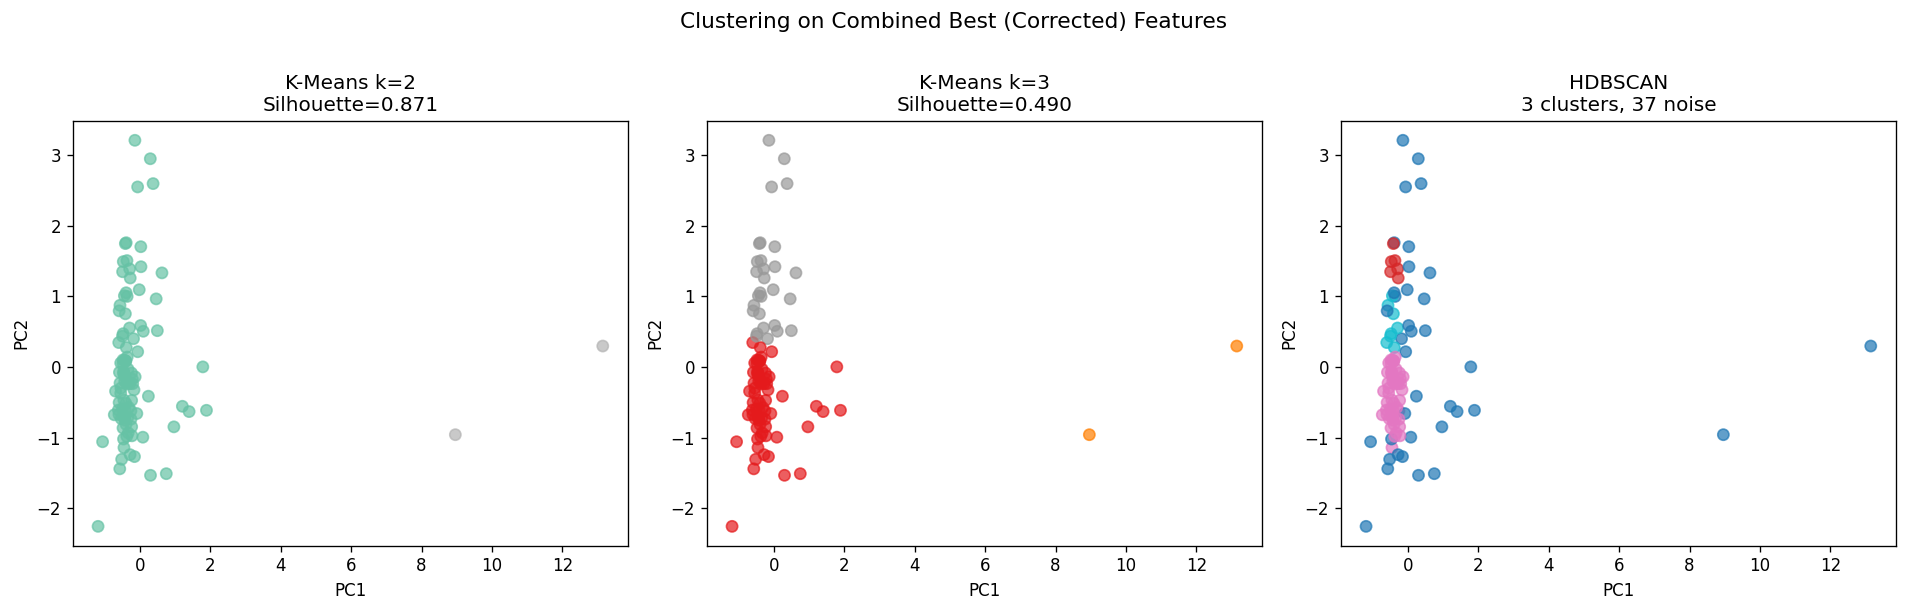

In [56]:
# Clustering visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# K=2
scores_comb = pca_results['Combined Best']['scores']
labels_k2 = km_results[2]['labels']
axes[0].scatter(scores_comb[:, 0], scores_comb[:, 1], c=labels_k2, cmap='Set2', alpha=0.7, s=45)
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')
axes[0].set_title(f'K-Means k=2\nSilhouette={km_results[2]["silhouette"]:.3f}')

# K=3
labels_k3 = km_results[3]['labels']
axes[1].scatter(scores_comb[:, 0], scores_comb[:, 1], c=labels_k3, cmap='Set1', alpha=0.7, s=45)
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2')
axes[1].set_title(f'K-Means k=3\nSilhouette={km_results[3]["silhouette"]:.3f}')

# HDBSCAN
if hdb_labels is not None:
    scatter = axes[2].scatter(scores_comb[:, 0], scores_comb[:, 1], c=hdb_labels, cmap='tab10', alpha=0.7, s=45)
    axes[2].set_xlabel('PC1'); axes[2].set_ylabel('PC2')
    n_cl = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
    axes[2].set_title(f'HDBSCAN\n{n_cl} clusters, {(hdb_labels==-1).sum()} noise')

plt.suptitle('Clustering on Combined Best (Corrected) Features', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

### 3.6 Outlier-Robust Analysis

- combining feedback from M3

Outliers identified (z > 3): ['Dexter2-Tag', 'Mifty-Tag']
N outliers: 2, N remaining: 99

Clean subset shape: (99, 4)

K-Means on outlier-removed subset:
  k   Silhouette Cluster Sizes
---------------------------------------------
  2        0.491   [np.int64(70), np.int64(29)]
  3        0.532   [np.int64(67), np.int64(26), np.int64(6)]
  4        0.413   [np.int64(39), np.int64(36), np.int64(19), np.int64(5)]


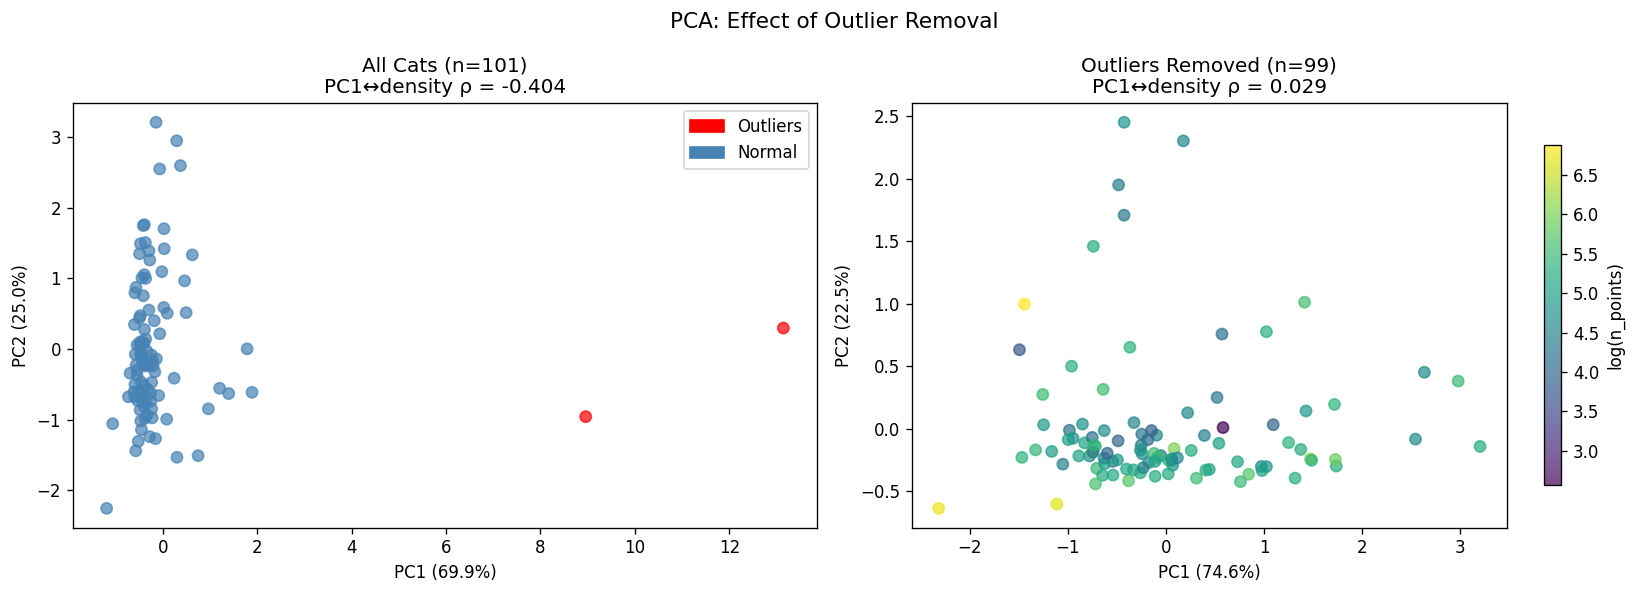


PCA comparison:
  With outliers:    PC1 = 69.9%, PC1↔density ρ = -0.404
  Without outliers: PC1 = 74.6%, PC1↔density ρ = +0.029


In [60]:
# Identify outliers formally using z-score on corrected features
z_rog = np.abs(stats.zscore(cat['radius_of_gyration_m'].fillna(cat['radius_of_gyration_m'].median())))
z_dpp = np.abs(stats.zscore(cat['dist_per_point_m'].fillna(cat['dist_per_point_m'].median())))
outlier_mask_full = (z_rog > 3) | (z_dpp > 3)

outlier_cats = cat.loc[outlier_mask_full, 'tag_id'].tolist()
print(f"Outliers identified (z > 3): {outlier_cats}")
print(f"N outliers: {outlier_mask_full.sum()}, N remaining: {(~outlier_mask_full).sum()}")

# Build clean feature matrix, align outlier mask to comb_idx
outlier_mask_comb = outlier_mask_full[comb_idx]
X_clean = X_comb_sc[~outlier_mask_comb]
clean_cat_idx = comb_idx[~outlier_mask_comb]
print(f"\nClean subset shape: {X_clean.shape}")

# PCA on clean subset
pca_clean = PCA()
scores_clean = pca_clean.fit_transform(X_clean)
pc1_rho_clean, _ = stats.spearmanr(scores_clean[:, 0], cat.loc[clean_cat_idx, 'n_points'].values)

# K-Means on clean subset
print("\nK-Means on outlier-removed subset:")
print(f"{'k':>3} {'Silhouette':>12} {'Cluster Sizes'}")
print("-" * 45)
km_clean_results = {}
for k in [2, 3, 4]:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = km.fit_predict(X_clean)
    sil = silhouette_score(X_clean, labels)
    sizes = sorted(pd.Series(labels).value_counts().values, reverse=True)
    km_clean_results[k] = {'labels': labels, 'silhouette': sil}
    print(f"{k:>3} {sil:>12.3f}   {sizes}")

# Side-by-side PCA plot: with vs without outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: all cats, outliers highlighted in red
colors_all = ['red' if o else 'steelblue' for o in outlier_mask_comb]
axes[0].scatter(pca_results['Combined Best']['scores'][:, 0],
                pca_results['Combined Best']['scores'][:, 1],
                c=colors_all, alpha=0.7, s=45)
axes[0].set_xlabel(f"PC1 ({pca_results['Combined Best']['pca'].explained_variance_ratio_[0]:.1%})")
axes[0].set_ylabel(f"PC2 ({pca_results['Combined Best']['pca'].explained_variance_ratio_[1]:.1%})")
axes[0].set_title(f"All Cats (n=101)\nPC1↔density ρ = {pca_results['Combined Best']['pc1_density_rho']:.3f}")
from matplotlib.patches import Patch
axes[0].legend(handles=[Patch(color='red', label='Outliers'), Patch(color='steelblue', label='Normal')])

# Right: outliers removed
sc = axes[1].scatter(scores_clean[:, 0], scores_clean[:, 1],
                     c=np.log1p(cat.loc[clean_cat_idx, 'n_points'].values),
                     cmap='viridis', alpha=0.7, s=45)
axes[1].set_xlabel(f"PC1 ({pca_clean.explained_variance_ratio_[0]:.1%})")
axes[1].set_ylabel(f"PC2 ({pca_clean.explained_variance_ratio_[1]:.1%})")
axes[1].set_title(f"Outliers Removed (n={len(X_clean)})\nPC1↔density ρ = {pc1_rho_clean:.3f}")
plt.colorbar(sc, ax=axes[1], label='log(n_points)', shrink=0.8)

plt.suptitle('PCA: Effect of Outlier Removal', fontsize=13)
plt.tight_layout()
plt.show()

print(f"\nPCA comparison:")
print(f"  With outliers:    PC1 = {pca_results['Combined Best']['pca'].explained_variance_ratio_[0]:.1%}, PC1↔density ρ = {pca_results['Combined Best']['pc1_density_rho']:+.3f}")
print(f"  Without outliers: PC1 = {pca_clean.explained_variance_ratio_[0]:.1%}, PC1↔density ρ = {pc1_rho_clean:+.3f}")

### 3.7 UMAP Embedding

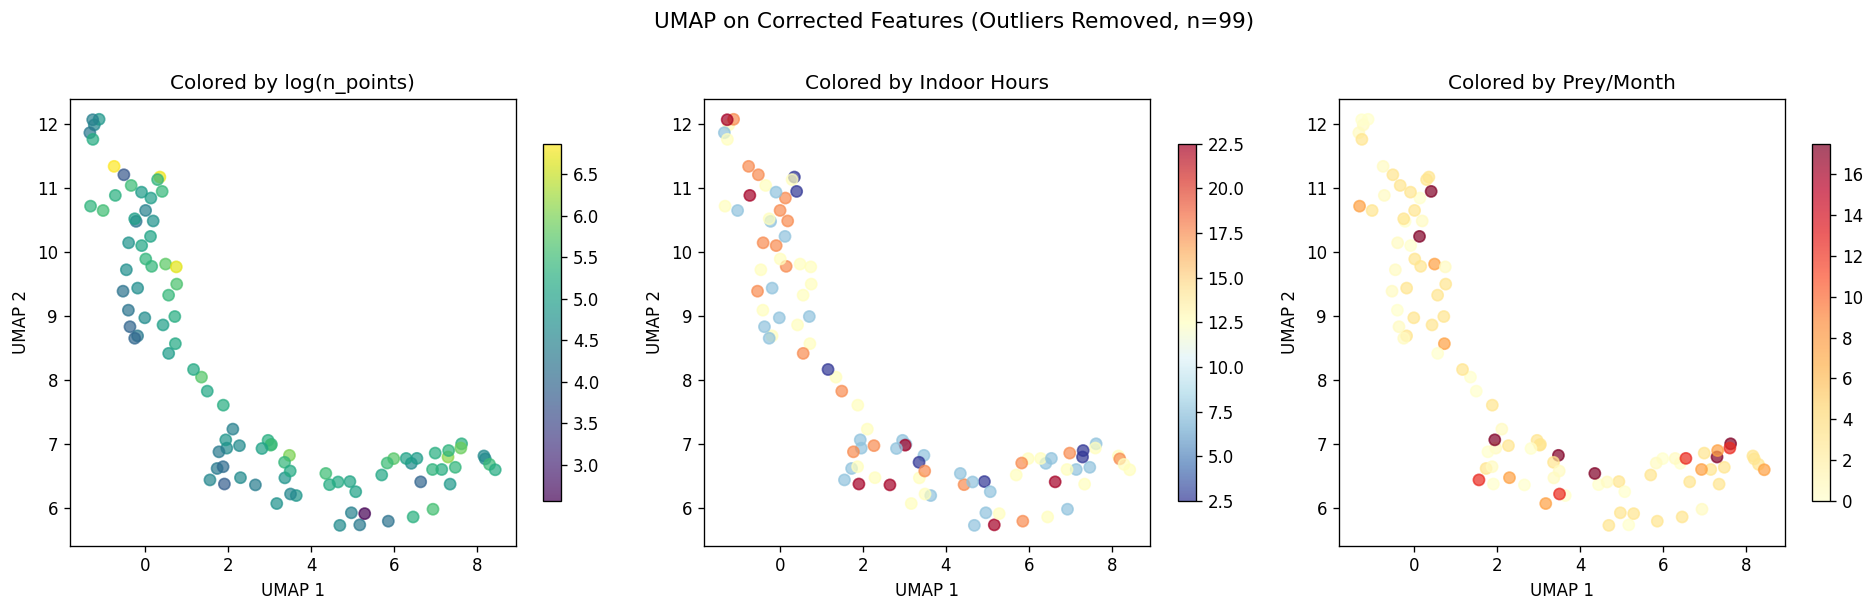

UMAP axis correlations (|ρ| > 0.2 shown):

  umap1:
    ↔ dist_per_point_m: ρ = +0.205 (p=0.042)
    ↔ median_step_m: ρ = +0.914 (p=0.000)
    ↔ bbox_resid: ρ = -0.269 (p=0.007)
    ↔ prey_p_month: ρ = +0.238 (p=0.017)

  umap2:
    ↔ median_step_m: ρ = -0.805 (p=0.000)

UMAP dim1 ↔ n_points: ρ = 0.166


In [62]:
try:
    import umap

    # Run UMAP on outlier-removed features for consistency with Section 3.6
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=SEED)
    umap_emb = reducer.fit_transform(X_clean)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # Color by density
    sc1 = axes[0].scatter(umap_emb[:, 0], umap_emb[:, 1],
                          c=np.log1p(cat.loc[clean_cat_idx, 'n_points'].values),
                          cmap='viridis', alpha=0.7, s=45)
    axes[0].set_title('Colored by log(n_points)')
    plt.colorbar(sc1, ax=axes[0], shrink=0.8)

    # Color by indoor hours
    hrs = cat.loc[clean_cat_idx, 'hrs_indoors'].values
    sc2 = axes[1].scatter(umap_emb[:, 0], umap_emb[:, 1],
                          c=hrs, cmap='RdYlBu_r', alpha=0.7, s=45)
    axes[1].set_title('Colored by Indoor Hours')
    plt.colorbar(sc2, ax=axes[1], shrink=0.8)

    # Color by prey per month
    prey = cat.loc[clean_cat_idx, 'prey_p_month'].values
    sc3 = axes[2].scatter(umap_emb[:, 0], umap_emb[:, 1],
                          c=prey, cmap='YlOrRd', alpha=0.7, s=45)
    axes[2].set_title('Colored by Prey/Month')
    plt.colorbar(sc3, ax=axes[2], shrink=0.8)

    for ax in axes:
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')

    plt.suptitle('UMAP on Corrected Features (Outliers Removed, n=99)', fontsize=13, y=1.01)
    plt.tight_layout()
    plt.show()

    # UMAP axis interpretation — what do the axes actually represent?
    umap_df = pd.DataFrame({'umap1': umap_emb[:, 0], 'umap2': umap_emb[:, 1]})
    umap_df.index = clean_cat_idx
    check_vars = combined_cols + ['n_points', 'hrs_indoors', 'prey_p_month']

    print("UMAP axis correlations (|ρ| > 0.2 shown):")
    for dim in ['umap1', 'umap2']:
        print(f"\n  {dim}:")
        for feat in check_vars:
            vals = cat.loc[clean_cat_idx, feat] if feat not in umap_df.columns else umap_df[feat]
            valid = pd.DataFrame({'u': umap_df[dim], 'f': cat.loc[clean_cat_idx, feat]}).dropna()
            if len(valid) > 10:
                rho, p = stats.spearmanr(valid['u'], valid['f'])
                if abs(rho) > 0.2:
                    print(f"    ↔ {feat}: ρ = {rho:+.3f} (p={p:.3f})")

    umap_rho, _ = stats.spearmanr(umap_emb[:, 0], cat.loc[clean_cat_idx, 'n_points'].values)
    print(f"\nUMAP dim1 ↔ n_points: ρ = {umap_rho:.3f}")

except ImportError:
    print("umap-learn not available")

### 3.8 Cross-Validation with Metadata

In [63]:
# Do corrected features align with known behavioral differences?
meta_vars = ['hrs_indoors', 'prey_p_month', 'age_years']
corrected_feats = combined_cols

print("Spearman correlations: Corrected features vs. Metadata")
print("=" * 65)
cross_corr = pd.DataFrame(index=corrected_feats, columns=meta_vars, dtype=float)
for feat in corrected_feats:
    for mv in meta_vars:
        valid = cat[[feat, mv]].dropna()
        if len(valid) > 10:
            rho, _ = stats.spearmanr(valid[feat], valid[mv])
            cross_corr.loc[feat, mv] = rho
print(cross_corr.round(3).to_string())

Spearman correlations: Corrected features vs. Metadata
                  hrs_indoors  prey_p_month  age_years
dist_per_point_m        0.054         0.097     -0.091
median_step_m          -0.103         0.191     -0.108
rog_resid               0.157        -0.123     -0.061
bbox_resid              0.204        -0.313      0.035


### 3.8 Ranking Change Analysis: Who's Most Affected by Correction?

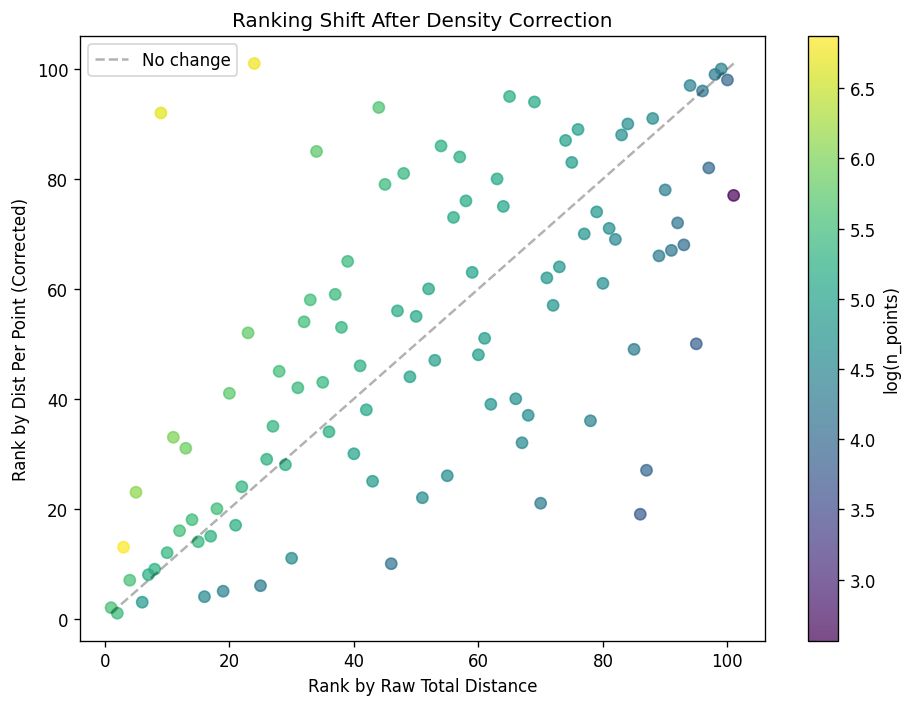

Rank correlation (raw vs corrected): ρ = 0.659
Mean rank change: 17.5 positions
Max rank change: 83 positions

Most affected by correction:
             tag_id  n_points  rank_raw_dist  rank_corrected_dpp  rank_change
          Teddy-Tag     791.0            9.0                92.0         83.0
           Bits-Tag     867.0           24.0               101.0         77.0
           Ebby-Tag      41.0           86.0                19.0         67.0
          Felix-Tag      51.0           87.0                27.0         60.0
Lightening Bugg-Tag     302.0           34.0                85.0         51.0


In [67]:
# Compare raw vs corrected rankings
cat['rank_raw_dist'] = cat['total_distance_m'].rank(ascending=False)
cat['rank_corrected_dpp'] = cat['dist_per_point_m'].rank(ascending=False)
cat['rank_change'] = (cat['rank_raw_dist'] - cat['rank_corrected_dpp']).abs()

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(cat['rank_raw_dist'], cat['rank_corrected_dpp'],
                c=np.log1p(cat['n_points']), cmap='viridis', alpha=0.7, s=45)
ax.plot([1, 101], [1, 101], 'k--', alpha=0.3, label='No change')
ax.set_xlabel('Rank by Raw Total Distance')
ax.set_ylabel('Rank by Dist Per Point (Corrected)')
ax.set_title('Ranking Shift After Density Correction')
plt.colorbar(sc, ax=ax, label='log(n_points)')
ax.legend()
plt.tight_layout()
plt.show()

rank_corr, _ = stats.spearmanr(cat['rank_raw_dist'], cat['rank_corrected_dpp'])
print(f"Rank correlation (raw vs corrected): ρ = {rank_corr:.3f}")
print(f"Mean rank change: {cat['rank_change'].mean():.1f} positions")
print(f"Max rank change: {cat['rank_change'].max():.0f} positions")

# Top 5 most affected cats
top_affected = cat.nlargest(5, 'rank_change')[['tag_id', 'n_points', 'rank_raw_dist', 'rank_corrected_dpp', 'rank_change']]
print(f"\nMost affected by correction:")
print(top_affected.to_string(index=False))

---
## Phase 4: Quantifying Signal vs. Noise

### Summary of Findings

- AI helped with formatting

In [73]:
print("=" * 70)
print("M4 SUMMARY: Density Artifact vs. Genuine Behavioral Signal")
print("=" * 70)

print("\n1. CONFOUND MECHANISM:")
print(f"   Sampling rate varies widely: median = {cat['sampling_rate_pph'].median():.2f} pts/hr, max = {cat['sampling_rate_pph'].max():.1f}")
print(f"   Duration ↔ n_points: ρ = {rho_dn:.3f} (not correlated — similar tracking durations)")
print(f"   Sampling rate ↔ n_points: ρ = {rho_sr:.3f} (strongly correlated)")
print(f"   → Variable sampling rate, not duration, drives the density confound")

print("\n2. CORRECTION EFFECTIVENESS (|ρ| with n_points):")
for name, res in [('Raw total_distance', corr_table.loc['total_distance_m', 'n_points']),
                  ('Raw dist_per_hour', corr_table.loc['dist_per_hour', 'n_points']),
                  ('Residualized: total_distance', corr_table.loc['total_distance_m', 'n_points'] if 'total_distance_m_resid' in resid_df.columns else None),
                  ('Subsampled', None),
                  ('Rate-based: dist_per_point', corr_table.loc['dist_per_point_m', 'n_points']),
                  ('Rate-based: median_step', corr_table.loc['median_step_m', 'n_points'])]:
    if res is not None:
        print(f"   {name:40s} ρ = {res:+.3f}")
    else:
        print(f"   {name:40s} (see table above)")

print("\n3. PCA STRUCTURE AFTER CORRECTION:")
for name, res in pca_results.items():
    ev = res['explained_var']
    print(f"   {name:20s}  PC1={ev[0]:.1%}, PC1↔density ρ={res['pc1_density_rho']:+.3f}")

print("\n4. BEHAVIORAL STRUCTURE:")
print(f"   K-Means k=2 silhouette (corrected): {km_results[2]['silhouette']:.3f}")
print(f"   Clustering still isolates outliers, not distinct behavioral types")
print(f"   Behavioral variation is continuous, not categorical")

print("\n5. VARIANCE DECOMPOSITION:")
for feat in ['total_distance_m', 'radius_of_gyration_m', 'bbox_area_deg2']:
    valid = cat[[feat, 'log_n_points']].dropna()
    lr = LinearRegression()
    lr.fit(valid[['log_n_points']], valid[feat])
    r2 = lr.score(valid[['log_n_points']], valid[feat])
    print(f"   {feat:30s}  {r2:.0%} density artifact, {1-r2:.0%} behavioral")

M4 SUMMARY: Density Artifact vs. Genuine Behavioral Signal

1. CONFOUND MECHANISM:
   Sampling rate varies widely: median = 0.90 pts/hr, max = 18.2
   Duration ↔ n_points: ρ = 0.016 (not correlated — similar tracking durations)
   Sampling rate ↔ n_points: ρ = 0.908 (strongly correlated)
   → Variable sampling rate, not duration, drives the density confound

2. CORRECTION EFFECTIVENESS (|ρ| with n_points):
   Raw total_distance                       ρ = +0.786
   Raw dist_per_hour                        ρ = +0.725
   Residualized: total_distance             ρ = +0.786
   Subsampled                               (see table above)
   Rate-based: dist_per_point               ρ = +0.158
   Rate-based: median_step                  ρ = +0.025

3. PCA STRUCTURE AFTER CORRECTION:
   Raw                   PC1=93.3%, PC1↔density ρ=+0.464
   Residualized          PC1=91.2%, PC1↔density ρ=-0.482
   Subsampled            PC1=74.2%, PC1↔density ρ=+0.380
   Combined Best         PC1=69.9%, PC1↔densit